In [118]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [119]:
with open('../names.txt') as f:
    words = f.read().splitlines()
# Create index representation of word/char
chars = sorted(list(set(''.join(words)+'.')))
idx2char = {idx:c for idx,c in enumerate(chars)}
char2idx = {c:idx for idx,c in enumerate(chars)}
block_size = 3
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = char2idx[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# Maunally run one epoch to check
1. what affect initial loss?
2. distribution of A1, what's good sign what's bad, what's the effect
3. what cause gradient vanishing/exploding, how to solve
4. batch norm
5. Wrap up

In [120]:
# manually make a forward pass to get loss
emb_hidden = 2
hidden_size = 200
C = torch.randn((len(char2idx), emb_hidden),requires_grad=True)
# emb can use onehot + @ or can use index C[X]
emb = F.one_hot(Xtr[:32],len(char2idx)).float() @ C
# emb.shape

W1 = torch.randn((emb_hidden*block_size, hidden_size),requires_grad=True)
b1 = torch.randn(hidden_size,requires_grad=True)
Z1 = emb.view(-1, emb_hidden*block_size) @ W1 + b1
A1 = Z1.tanh()

W2 = torch.randn((hidden_size, len(char2idx)),requires_grad=True)
b2 = torch.randn(len(char2idx),requires_grad=True)
A2 = A1 @ W2 + b2

prob = A2.exp() / A2.exp().sum(dim=1,keepdim=True)
loss = -prob[torch.arange(len(Xtr[:32])),Ytr[:32]].log().mean()
print(f'{loss=:.4f}')

loss=22.8529


In [121]:
# 1. prob distribution uneven ----> high loss (negative mean log of prob)
# how to initialize weight, to make first few epochs more efficient
# not learning from high loss but start from low loss
prob[0]

tensor([4.8719e-03, 7.1568e-08, 1.0371e-15, 4.3385e-06, 6.8390e-06, 3.3062e-13,
        6.3365e-05, 2.6260e-01, 7.3244e-01, 1.9716e-10, 5.4905e-07, 9.9378e-10,
        8.3535e-11, 3.3243e-08, 3.9081e-17, 1.1368e-06, 1.1899e-05, 9.6715e-09,
        5.1072e-13, 9.0480e-13, 1.2491e-08, 2.4549e-10, 1.2227e-06, 4.0920e-17,
        2.3426e-11, 4.3412e-08, 2.0463e-08], grad_fn=<SelectBackward0>)

In [122]:
# 1. if nothing learnt yet, should have equal prob, so 
# lower the weight when intial ------> lower logits(A2) -----> even prob
W2 = torch.randn((hidden_size, len(char2idx)),requires_grad=True) * 0.01
b2 = torch.randn(len(char2idx),requires_grad=True)
A2 = A1 @ W2 + b2

prob = A2.exp() / A2.exp().sum(dim=1,keepdim=True)
loss = -prob[torch.arange(len(Xtr[:32])),Ytr[:32]].log().mean()
print(f'{loss=:.4f}')

loss=3.7215


In [123]:
prob[0]

tensor([0.0317, 0.1684, 0.0148, 0.0796, 0.0206, 0.0207, 0.0124, 0.0198, 0.0877,
        0.0033, 0.0148, 0.0089, 0.0468, 0.0341, 0.0567, 0.0250, 0.0230, 0.0132,
        0.0260, 0.1520, 0.0130, 0.0204, 0.0418, 0.0397, 0.0184, 0.0026, 0.0045],
       grad_fn=<SelectBackward0>)

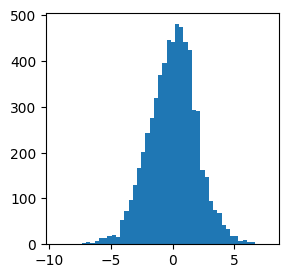

In [124]:
# 2. Z1 too big, after squash activation, value is staturated
plt.figure(figsize=(3,3))
plt.hist(Z1.view(-1).tolist(),bins=50)
plt.show()

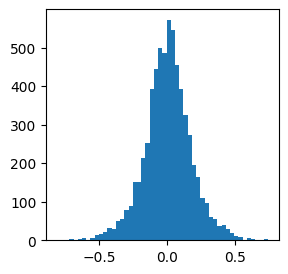

In [125]:
W1 = torch.randn((emb_hidden*block_size, hidden_size),requires_grad=True) * 0.1
b1 = torch.randn(hidden_size,requires_grad=True) * 0.01
Z1 = emb.view(-1, emb_hidden*block_size) @ W1 + b1
plt.figure(figsize=(3,3))
plt.hist(Z1.view(-1).tolist(),bins=50)
plt.show()
# less extreme values

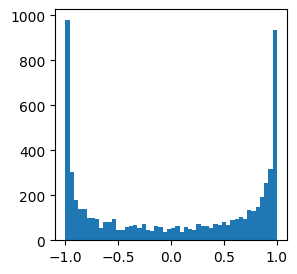

In [126]:
# saturated values, all -1 and 1
plt.figure(figsize=(3,3))
plt.hist(A1.view(-1).tolist(), bins = 50)
plt.show()

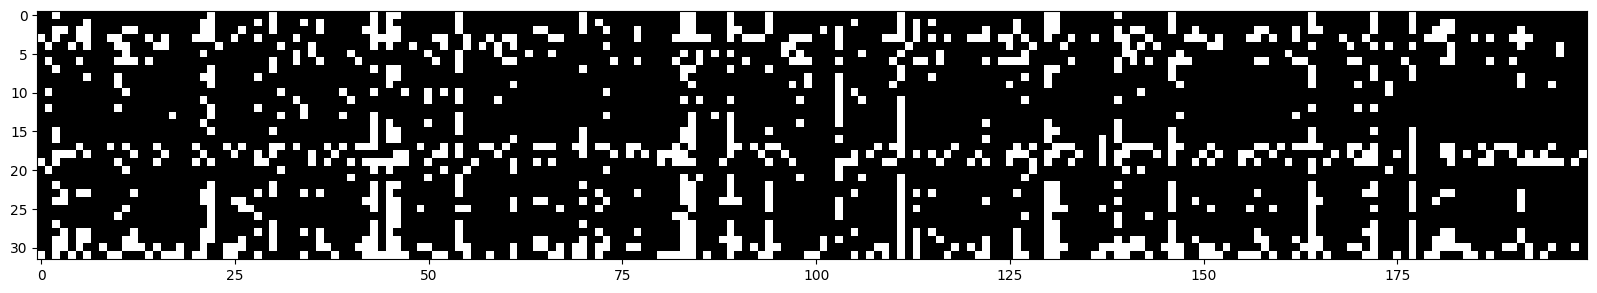

In [127]:
plt.figure(figsize=(20,10))
plt.imshow(abs(A1)>0.99, cmap='gray',interpolation='nearest')
plt.show()

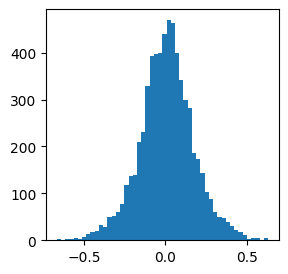

In [128]:
A1 = Z1.tanh()
# saturated values, all -1 and 1
plt.figure(figsize=(3,3))
plt.hist(A1.view(-1).tolist(), bins = 50)
plt.show()

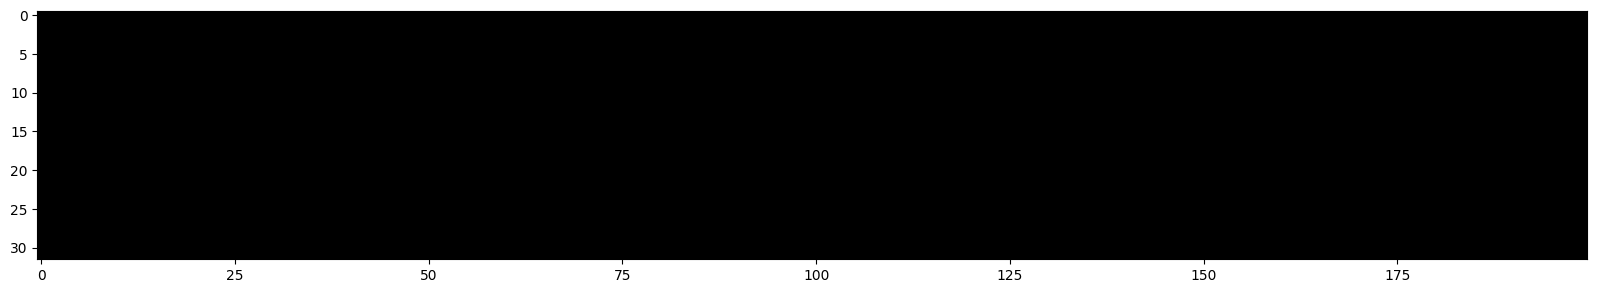

In [129]:
plt.figure(figsize=(20,10))
plt.imshow(abs(A1)>0.99, cmap='gray',interpolation='nearest')
plt.show()

In [130]:
# 2. How to find the optimal scaling value for weight?
# Want z1 have guassian distribution and small value, 
# Kaiming He paper
x = torch.randn(1000,10)
w = torch.randn(10,200)
y = x @ w
print('x: ', x.mean(), x.std())
print('y before scale: ',y.mean(), y.std())
w = torch.randn(10,200) / 10**0.5
y = x@w
print('y after scale: ',y.mean(), y.std())

x:  tensor(-0.0032) tensor(0.9987)
y before scale:  tensor(0.0097) tensor(3.1139)
y after scale:  tensor(0.0004) tensor(0.9800)


In [104]:
# 3. BatchNorm:
# Same idea before, control the statistics of activations in the neural networks
# we don't want gradient from squash activation function being 0
# ----> we don't want to have value after tanh/sigmoid take extreme values(-1,1,0)
# ----> abs value of Z too big will cause A take extreme values
# ----> adjust value of Z:
# ----> 1. scale weight, Z = wx+b, scale w to a small number Z = (0.01w)@x + b
# ----> 2. find optimal scaler, scaler = d_in ** (-0.5)
# ----> 3. why not scale Z directly? BatchNorm

# BatchNorm also have regularzation effect since when doing normalization,
# it group the sample in the batch, so when backprop, each sample not independent, 
# causing small fluctuation to other samples, have regularzation effect

In [6]:
# Again, group all parameters here and count total number of parameters

# ---------------- Initialization -------------------------
g = torch.Generator().manual_seed(1234)
emb_hidden = 2
hiddensize = 100

C = torch.randn((len(char2idx), emb_hidden),generator=g)
W1 = torch.randn((emb_hidden*block_size, hiddensize),generator=g)
# Don't need b1 since it will be cancel out when subtract mean of the batch
# b1 = torch.randn(hiddensize,generator=g) 
W2 = torch.randn((hiddensize, len(char2idx)),generator=g)
b2 = torch.randn(len(char2idx),generator=g)

# BatchNorm parameters
bngain = torch.ones((1, hidden_size))
bnbias = torch.zeros((1, hidden_size))
bnmean_running = torch.zeros((1,hiddensize))
bnstd_running = torch.zeros((1,hidden_size))

parameters = [C, W1, W2, b2, bngain, bnbias]
print('total num_of_parameters: ',sum([parameter.nelement() for parameter in parameters]))
# set require grad to all params
for i in parameters:
    i.requires_grad = True


# --------------------- Training ----------------------------
loss_hist = []
batch_size = 10000
n_iter = 1000
for epoch in range(n_iter):
    minibatch = torch.randint(0,len(Xtr), (batch_size,))
    emb = C[Xtr[minibatch,:]]
    Z1 = emb.view(-1, block_size*emb_hidden) @ W1

    # ---------------------- BatchNorm --------------------------
    bn_mean = (Z1 - Z1.sum(dim=0,keepdim=True))
    bn_std = Z1.std(dim=0,keepdim=True)
    Z1 = bngain * bn_mean/bn_std + bnbias
    bnmean_running = 0.999 * bnmean_running + 0.001 * bn_mean
    bnstd_running = 0.999 * bnstd_running + 0.001 * bn_std
    # -----------------------------------------------------------

    A1 = Z1.tanh()
    logits = A1 @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[minibatch])
    for i in parameters:
        i.grad = None
    # if epoch%10 == 0:
    #     print(f"{epoch=}: {loss=:.4f}") 
    loss_hist.append(loss.item())
    loss.backward()
    for i in parameters:
        i.data -= 0.1 * i.grad


total num_of_parameters:  3481


In [214]:
# 5 Wrap up
from typing import Any


class Linear:
    def __init__(self, d_in, d_out, bias = True) -> None:
        self.weight = torch.randn((d_in, d_out), generator = g)/ d_in ** 0.5
        self.b = torch.zeros(d_out) if bias else None
        self.bias = bias
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias:
            self.out += self.b
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.b is None else [self.b])
    
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.train = True

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.train:
            bn_mean = x.mean(dim=0,keep_dim=True)
            bn_var = x.var(dim=0,keep_dim=True)
        else:
            bn_mean = self.running_mean
            bn_var = self.running_var

        x_out = (x-bn_mean) / torch.sqrt(bn_var + self.eps)
        self.out = self.gamma * x_out + self.beta
        if self.train:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * bn_mean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * bn_var
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [260]:
emb_hidden = 10
hidden_size = 100
vocab_size = len(char2idx)
g = torch.Generator().manual_seed(1234)
C = torch.randn((vocab_size, emb_hidden), generator=g)
layers = [
    Linear(block_size*emb_hidden, hidden_size,False),
    Tanh(),
    Linear(hidden_size, hidden_size,False),
    Tanh(),
    Linear(hidden_size, hidden_size,False),
    Tanh(),
    Linear(hidden_size, hidden_size,False),
    Tanh(),
    Linear(hidden_size, hidden_size,False),
    Tanh(),
    Linear(hidden_size, hidden_size,False),
    Tanh(),
    Linear(hidden_size, hidden_size,False),
    Tanh(),
    # Linear(hidden_size, hidden_size,False),
    # Tanh(),
    # Linear(hidden_size, hidden_size,False),
    # Tanh(),
    # Linear(hidden_size, hidden_size,False),
    # Tanh(),
    Linear(hidden_size, vocab_size)
]
with torch.no_grad():
    layers[-1].weight *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 0.5

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(i.nelement() for i in parameters))
for p in parameters:
    p.requires_grad = True

65997


In [261]:
max_epoch = 20
batch_size = 256
max_step = torch.floor(torch.tensor(len(Xtr)/batch_size)).int()
lr = 0.1
loss_history = []
for i in range(max_epoch):
    for j in range(max_step.item()):
        xb, yb = Xtr[j*batch_size:(j+1)*batch_size], Ytr[j*batch_size:(j+1)*batch_size]
        # print(xb.shape)
        emb = C[xb]
        x = emb.view(emb.shape[0],-1)
        # break
        for l in layers:
            x = l(x)
        loss = F.cross_entropy(x, yb)
        loss_history.append(loss.item())

        for l in layers:
            l.out.retain_grad()
        for p in parameters:
            p.grad = None
        loss.backward()

        for p in parameters:
            p.data += -lr*p.grad
    break


layer 1 (      Tanh): mean +0.02, std 0.39, saturated: 0.01%
layer 3 (      Tanh): mean -0.00, std 0.19, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.11, saturated: 0.00%
layer 7 (      Tanh): mean -0.00, std 0.06, saturated: 0.00%
layer 9 (      Tanh): mean -0.00, std 0.04, saturated: 0.00%
layer 11 (      Tanh): mean +0.00, std 0.03, saturated: 0.00%
layer 13 (      Tanh): mean -0.00, std 0.02, saturated: 0.00%


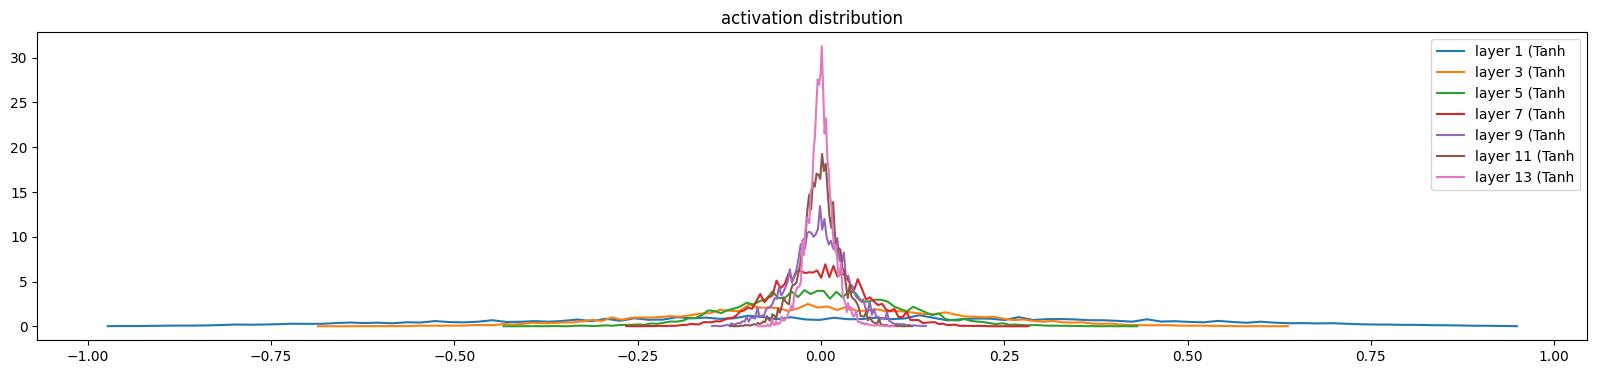

In [262]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')
plt.show()

layer 1 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 3 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 9 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 13 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


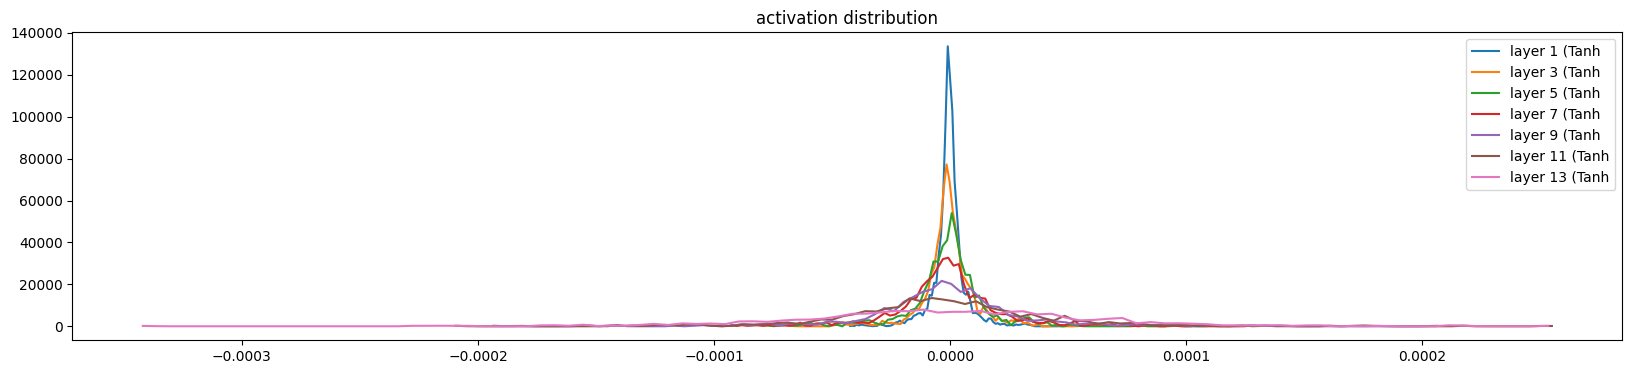

In [264]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')
plt.show()